In [1]:
import numpy as np
import scipy as sp
import sympy as sm
import pandas as pd
import timeit
import matplotlib.pyplot as plt


In [2]:
x = sm.Symbol('x')

In [3]:
df = 6*0.01*((1/6)*x**6 - (1/3)*x**3 - (1/0.05)*x**2 - 1.5*x - 1.*x**3)
Vdf = -1*sm.diff(df, x)
Vdf


-0.06*x**5 + 0.24*x**2 + 2.4*x + 0.09

In [4]:
df

0.01*x**6 - 0.08*x**3 - 1.2*x**2 - 0.09*x

In [5]:
mu, x = sm.symbols('mu, x')
vdp = mu*(3.5-0.25*x**3 + 2*x)
vdp1 = sm.lambdify([mu, x], vdp)

In [6]:
I0, k, c, F, Ac_F, r, F_p  = sm.symbols('I0, k, c, F, A_c_F, r, F_p')
c = I0 + Ac_F/(1+ sm.exp(-r*(F - F_p)))
c
 
c1 = c.subs({I0 : 0.5, Ac_F: 4, r : 1.2, F_p : 0.5}) ##Ac_F = 2 for higher adaptive capacity
c2 = sm.lambdify(F, c1, "numpy" )

In [7]:
t, f0 = sm.symbols('t, f_0')
F = f0*sm.sin(t) + 1.1*f0
F

f_0*sin(t) + 1.1*f_0

In [8]:
F1 = sm.lambdify([f0, t], F, "numpy")
tm = np.linspace(0, 100, 10001)
F2=F1(10,tm)
F2

array([11.        , 11.09999833, 11.19998667, ...,  5.76490401,
        5.85036632,  5.93634359])

<IPython.core.display.Javascript object>


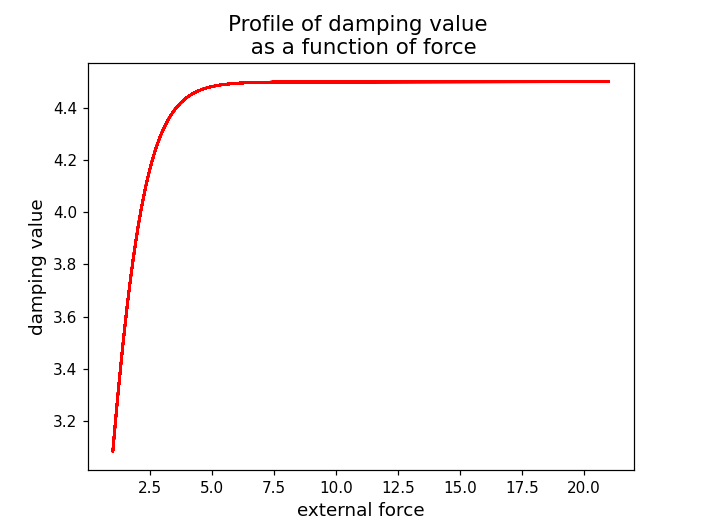

Text(0.5, 1.0, 'Profile of damping value \n as a function of force')

In [9]:
get_ipython().run_line_magic('matplotlib', 'notebook')
plt.plot(F2, c2(F2), c = 'red')
plt.xlabel("external force",fontsize =12); plt.ylabel("damping value", fontsize =12)
plt.title("Profile of damping value \n as a function of force", fontsize =14)


In [10]:
I0, k, c, F, Ac_F, r, F_p  = sm.symbols('I0, k, c, F, A_c_F, r, F_p')
c = I0 + Ac_F/(1+ sm.exp(-r*(F - F_p)))
k1 = c.subs({I0 : 0.5, Ac_F: 2, r : 0.6, F_p : 0.5}) # Ac_F = 1 for lower adaptive capacity
k2 = sm.lambdify(F, k1, "numpy" )

Text(0.5, 1.0, 'Profile of spring value \n as a function of force')

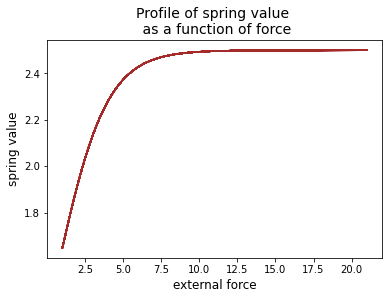

In [11]:
get_ipython().run_line_magic('matplotlib', 'inline')
plt.plot(F2, k2(F2), c = 'brown')
plt.xlabel("external force", fontsize =12); plt.ylabel("spring value", fontsize =12)
plt.title("Profile of spring value \n as a function of force", fontsize =14)

In [12]:
chigh = c.subs({I0 : 0.25, Ac_F: 4, r : 1.2, F_p : 2.5}) ##Ac_F = 2 for higher adaptive capacity
cH = sm.lambdify(F, chigh, "numpy" )

clow = c.subs({I0 : 0.25, Ac_F: 2, r : 1.2, F_p : 2.5}) 
cL = sm.lambdify(F, clow, "numpy" )

<IPython.core.display.Javascript object>


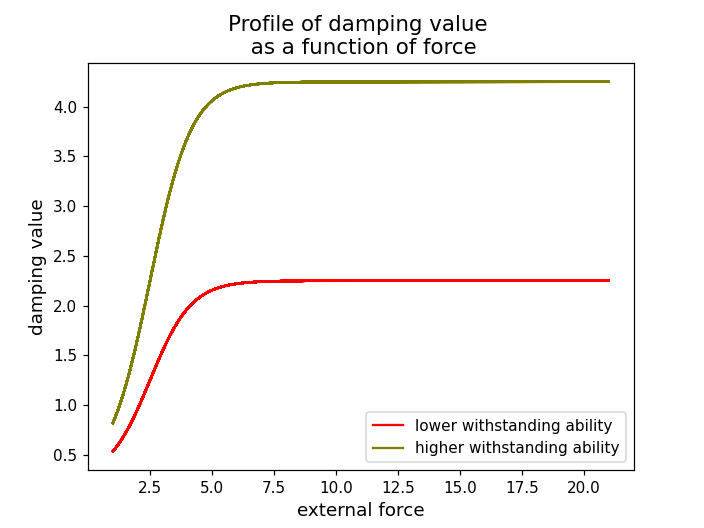

Text(0.5, 1.0, 'Profile of damping value \n as a function of force')

In [13]:
get_ipython().run_line_magic('matplotlib', 'notebook')
plt.plot(F2, cL(F2), c = 'red', label = "lower withstanding ability")
plt.plot(F2, cH(F2), c = 'olive', label = "higher withstanding ability")
plt.legend()
plt.xlabel("external force",fontsize =12); plt.ylabel("damping value", fontsize =12)
plt.title("Profile of damping value \n as a function of force", fontsize =14)

In [14]:
khigh = c.subs({I0 : 0.5, Ac_F: 2, r : 0.6, F_p : 0.5}) 
kH = sm.lambdify(F, khigh, "numpy" )

klow = c.subs({I0 : 0.5, Ac_F: 1, r : 0.6, F_p : 0.5}) 
kL = sm.lambdify(F, klow, "numpy" )

<IPython.core.display.Javascript object>


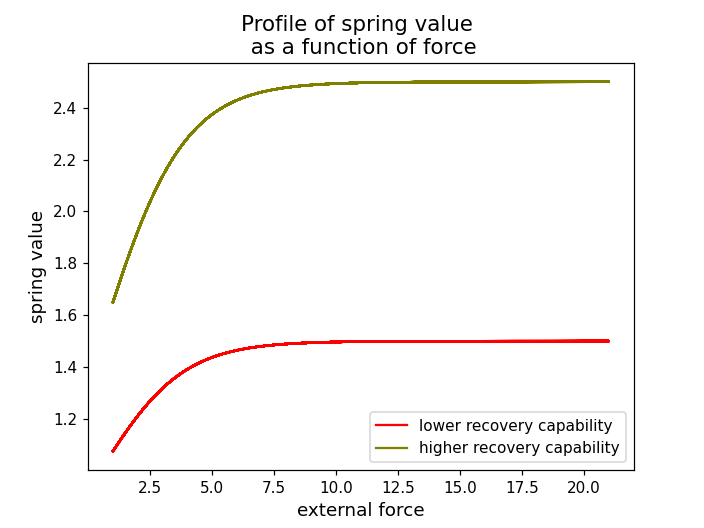

Text(0.5, 1.0, 'Profile of spring value \n as a function of force')

In [15]:
get_ipython().run_line_magic('matplotlib', 'notebook')
plt.plot(F2, kL(F2), c = 'red', label = "lower recovery capability")
plt.plot(F2, kH(F2), c = 'olive', label = "higher recovery capability")
plt.legend()
plt.xlabel("external force", fontsize =12); plt.ylabel("spring value", fontsize =12)
plt.title("Profile of spring value \n as a function of force", fontsize =14)

In [16]:
def nonSDMS_nonF_fun_LR(t, u, M, tend, t_step, F):
    
    from scipy.interpolate import interp1d

    x1 = u[0]
    x2 = u[1]
    
    xs = np.arange(len(F))
    y_interp = interp1d(xs, F)
    Frc = y_interp(t/t_step)
    
#     print(t)
#     print([\Frc\, Frc])
    ##Force dependent spring-damper##
    Ki = kL(Frc); Ci = cL(Frc); 
#     print(['Ki', Ki]); print(['Ci', Ci])
    ##Dynamic potential##

    y2int = Ki*df
    y1dif = -1*sm.diff(y2int, x)
    y1dif_fun = sm.lambdify(x, y1dif)
    spring_val = (y1dif_fun(x1))
#     print(["spring cons", spring_val ])
    
    ##Dynamic damper 
    damp_cons = Ci*0.5*(3.5-0.25*x1**3 + 2*x1)
#     print(["damper cons", damp_cons ])

    du = np.zeros([2, 1])

    du[0] = x2
    du[1] = (1/M)*(Frc - damp_cons*x2 + spring_val)

    du = du.reshape(2,)

    return(du)


In [17]:
def nonSDMS_nonF_fun_HR(t, u, M, tend, t_step, F):
    
    from scipy.interpolate import interp1d

    x1 = u[0]
    x2 = u[1]
    
    xs = np.arange(len(F))
    y_interp = interp1d(xs, F)
    Frc = y_interp(t/t_step)
    
#     print(t)
#     print([\Frc\, Frc])
    ##Force dependent spring-damper##
    Ki = kH(Frc); Ci = cH(Frc); 
#     print(['Ki', Ki]); print(['Ci', Ci])
    ##Dynamic potential##

    y2int = Ki*df
    y1dif = -1*sm.diff(y2int, x)
    y1dif_fun = sm.lambdify(x, y1dif)
    spring_val = (y1dif_fun(x1))
#     print(["spring cons", spring_val ])
    
    ##Dynamic damper 
    damp_cons = Ci*0.5*(3.5-0.25*x1**3 + 2*x1)
#     print(["damper cons", damp_cons ])

    du = np.zeros([2, 1])

    du[0] = x2
    du[1] = (1/M)*(Frc - damp_cons*x2 + spring_val)

    du = du.reshape(2,)

    return(du)


In [18]:
import random as rn
import pylab as pl

get_ipython().run_line_magic('matplotlib', 'inline')
def varying_extForce(N, Ts, ampl, mg):
    x0=pl.arange(0,N,Ts)
    sigs = np.zeros([10, len(x0)])

    phi = pl.linspace(0.001, 0.3, 100)
    amp = pl.linspace(2, 5, 100)

    for i in np.arange(10):

        amp1 = amp[rn.randint(0, 99)]
        phi1 = phi[rn.randint(0, 99)]

        y1= (amp1*pl.sin(phi1*pl.pi*x0) + mg)
        sigs[i,:] = y1
        
    sigs1 = ampl*np.apply_along_axis(np.mean, 0, sigs)
    plt.plot(sigs1)
    return(sigs1)

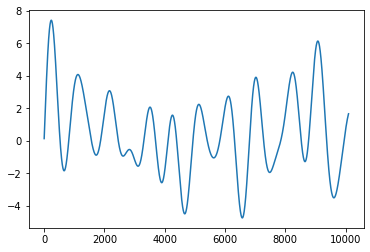

In [26]:
from scipy.integrate import solve_ivp
    
tend = 100
t_step = 0.01
t_span = (0, tend)
tint = np.linspace(0, tend, int(tend/t_step))
get_ipython().run_line_magic('matplotlib', 'inline')
extF= varying_extForce(tend+1, t_step, 2.5, 0.05)



In [30]:
u0=np.array([-1, 0.1])
p = (1, tend, t_step, extF)
start_time = timeit.default_timer()
slL = solve_ivp (nonSDMS_nonF_fun_LR, t_span, u0, args = p, t_eval = tint, method= 'RK45', rtol=1e-06, atol=1e-06)
print(timeit.default_timer() - start_time)


40.60883685294539


In [31]:
u0=np.array([-1, 0.1])
p = (1, tend, t_step, extF)
start_time = timeit.default_timer()
slH = solve_ivp (nonSDMS_nonF_fun_HR, t_span, u0, args = p, t_eval = tint, method= 'RK45', rtol=1e-06, atol=1e-06)
print(timeit.default_timer() - start_time)

32.10550724505447


<IPython.core.display.Javascript object>


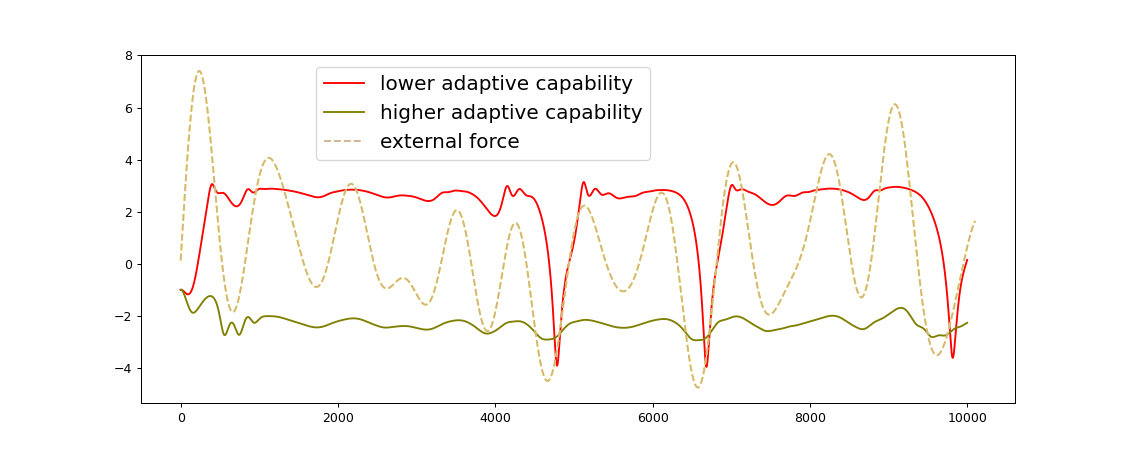

In [45]:
get_ipython().run_line_magic('matplotlib', 'notebook')

plt.plot(slL.y[0], c = 'red', label = "lower adaptive capability" )
plt.plot(slH.y[0], c = 'olive', label = "higher adaptive capability")
plt.plot(extF, '--', c = 'yellow')
plt.plot(extF, '--', c = 'tan', label = "external force")

plt.legend(fontsize=16, loc= (0.2, 0.7))
plt.show()


In [26]:
for i in np.arange(1000):
    
    extF= varying_extForce(tend+0.01, t_step, 0.6, 0.05)
    extF1 = extF[:-1]

    u0=np.array([-1, 0.1])
    p = (1, tend, t_step, extF)
    start_time = timeit.default_timer()
    slL = solve_ivp (nonSDMS_nonF_fun_LR, t_span, u0, args = p, t_eval = tint, method= 'RK45', rtol=1e-06, atol=1e-06)
    print(timeit.default_timer() - start_time)
    
    u0=np.array([-1, 0.1])
    p = (1, tend, t_step, extF)
    start_time = timeit.default_timer()
    slH = solve_ivp (nonSDMS_nonF_fun_HR, t_span, u0, args = p, t_eval = tint, method= 'RK45', rtol=1e-06, atol=1e-06)
    print(timeit.default_timer() - start_time)
    
    id='{0:04}'.format(i)
    sdms_df = pd.DataFrame({'low': slL.y[0], 'high' : slH.y[0], 'force': extF1})    
    fnm = "/home/karthik/jupyter_dir/SDMS/differential_adaptive_capa_finfo/simu_" + id + ".csv"
    sdms_df.to_csv(fnm)
    print(i)


25.240356961992802
27.312791025004117
0
25.415661263017682
27.165315256017493
1
24.15425512799993
25.66302668102435
2
25.142459819006035
26.980978166975547
3
23.243041792011354
24.73035895699286
4
25.1689943659876
26.73597127798712
5
25.097463117010193
26.900959716993384
6
23.832044273003703
25.057995298004244
7
25.79253981699003
27.22429250497953
8
24.678845354996156
26.6885952539742
9
24.679403665009886
26.246384530997602
10
24.97959757098579
26.772348976985086
11
24.39749688701704
26.303209886013065
12
25.06825154100079
26.871172779996414
13
24.473524954984896
25.885353541991208
14
23.596342708013253
25.190478562028147
15
25.787729330011643
27.460347850981634
16
25.18003602497629
27.338691569981165
17
23.743677049991675
25.078343806002522
18
25.506004794006003
27.47053082799539
19
25.097672520991182
26.11418224297813
20
25.236756837985013
26.712553239020053
21
27.021421409008326
28.697881361003965
22
24.563495385984425
26.033269563980866
23
26.435911930020666
27.55142125498969
24
25

25.61851430099341
201
26.0053834010032
27.491545266995672
202
24.992007855005795
27.79857990902383
203
23.84637862999807
27.220781598007306
204
25.527036729996325
28.24438175497926
205
25.1550725439738
25.42846100399038
206
25.736108207987854
26.529656612023246
207
25.529042282985756
25.96678731200518
208
26.312764700007392
27.732743189990288
209
22.830821720999666
25.6781376300205
210
24.930015667021507
28.366293113998836
211
24.1440369420161
26.8327010779758
212
23.559784758021124
26.574061859981157
213
28.03915464799502
29.050274326000363
214
23.982504665997112
23.54971597599797
215
25.964508044999093
26.639846664998913
216
24.891249437991064
25.166976780019468
217
25.16782051397604
25.24371807501302
218
26.087782837013947
26.922039216005942
219
25.77639033398009
27.191644990001805
220
24.052923198003555
27.0621047510067
221
23.840012907981873
27.39155167498393
222
23.852019412996015
26.54964059899794
223
26.35795346100349
29.93244265098474
224
22.872265924001113
26.084963784000138


24.558080629998585
28.13299578599981
401
22.817518569005188
24.408642249996774
402
25.572006675996818
24.657152233994566
403
25.35829895202187
29.372942866000813
404
26.704182408982888
28.273904114001198
405
27.463695874001132
26.633180778997485
406
24.655234609002946
28.293370225990657
407
23.1835035670083
24.286808745993767
408
27.105892238992965
27.116633747995365
409
25.05542338799569
29.35373330200673
410
24.960402237978997
26.403342625009827
411
25.92726340299123
25.06095459702192
412
21.426693485991564
22.273126437008614
413
25.199589172989363
23.86356933499337
414
23.849086641013855
27.5947132659785
415
27.08703882500413
29.19130934801069
416
26.46605470101349
26.27150470999186
417
25.220577272004448
29.195598727004835
418
24.313335954997456
25.620344519003993
419
25.0453051069926
29.518343748000916
420
25.243016989988973
27.402544553013286
421
26.717918868991546
25.431562690006103
422
22.66674580000108
26.13629780098563
423
23.70869246197981
25.789252971997485
424
26.367302166

24.296124661021167
29.367550308990758
600
25.498442624986637
27.440808994986583
601
24.428773700026795
28.475365169986617
602
23.35926954098977
24.703720903984504
603
23.073770602990407
27.48771461402066
604
21.46175904601114
22.852926129009575
605
22.744035805983003
23.87671001799754
606
26.398806709999917
24.749091067002155
607
23.124372377002146
24.91010906500742
608
21.316754536004737
25.584447763016215
609
22.8469858400058
24.45923922699876
610
23.000636186014162
27.7640377250209
611
24.070500283996807
25.584842967014993
612
22.27091828500852
23.700122954003746
613
27.501406184979714
26.295755764003843
614
22.86381345099653
24.1868258479808
615
27.227585415006615
26.418655020010192
616
23.36553023001761
25.029970578005305
617
26.583702820993494
25.64202440500958
618
22.180046102992492
23.713358160021016
619
24.389807800995186
29.825237475015456
620
22.16822874499485
23.957741010002792
621
23.213163979991805
24.822509696008638
622
26.241049809003016
24.548706137982663
623
24.601040

23.40450021898141
29.077068599988706
799
21.812334387010196
22.61551256699022
800
23.691615321993595
25.32608764100587
801
22.97285933198873
28.71235334701487
802
23.512438956007827
25.030582938023144
803
22.786549691023538
23.934991757007083
804
22.434006288007367
28.07680677200551
805
23.928002152009867
25.7049016339879
806
22.872483546001604
24.43332919399836
807
23.815442227991298
29.537321236013668
808
22.695182977011427
24.248547697992763
809
21.361406256997725
22.18407031201059
810
24.020167159003904
29.942283231997862
811
22.44863897198229
23.460824523994233
812
23.09624742498272
24.898658935009735
813
24.385760098986793
29.707052976998966
814
22.616675806988496
24.21935365398531
815
22.339536165003665
23.102307079010643
816
23.004252787999576
28.78315500600729
817
20.972931121999864
22.37580832099775
818
22.656198965996737
24.168963743024506
819
22.901662188000046
28.472170165012358
820
22.470796369976597
23.766843975987285
821
23.030639753007563
24.51486078099697
822
24.60567

22.67290725299972
998
23.183615007001208
24.66517189500155
999


In [ ]:
# import import_ipynb
# get_ipython().run_line_magic('run', '/home/karthik/jupyter_dir/trophic_temp/trophic_temp/IRI_calc.ipynb')


In [ ]:
# RRts1 = resilience_calc_func(slL.y[0])
# RRts2 = resilience_calc_func(slH.y[0])


In [ ]:
# RRts = (np.vstack((RRts1, RRts2)))
# np.transpose(RRts)


# # In[40]:


# from scipy import stats

# retrt = stats.zscore(RRts, axis=0)
# retrt1 = np.apply_along_axis(np.mean, 1, retrt)
# retrt1